In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Problem2

In [1]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']
data_nb = pd.concat([X, y], axis=1)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of data: ", data_nb.shape)
print("Distribution of label: \n", y.value_counts())

NameError: name 'pd' is not defined

In [155]:
### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index().iloc[:,1:]
### Partition Data
data_cv = np.array_split(data_temp, 10)

In [156]:
class Naive_Bayers:
    def __init__(self) -> None:
        None

    def fit(self, X, y):
        self.n, self.m = X.shape
        self.pi = y.sum()/y.shape[0]
        self.lambda_0 = (1 + X[y == 0].sum(axis = 0))/(1 + y.shape[0] - y.sum())
        self.lambda_0 = self.lambda_0
        self.lambda_1 = (1 + X[y == 1].sum(axis = 0))/(1 + y.sum())
        self.lambda_1 = self.lambda_1
    
    def predict(self, X):
        # print('X: ', X.shape)
        # print('lambda0: ', self.lambda_0.shape)
        # print(np.sum(X*np.log(self.lambda_1.T), axis=1))

        p0 = (np.log(1-self.pi) + np.sum(X*np.log(self.lambda_0.T), axis=1) - np.sum(self.lambda_0)).reset_index(drop=True)
        p1 = (np.log(self.pi) + np.sum(X*np.log(self.lambda_1.T), axis=1) - np.sum(self.lambda_1)).reset_index(drop=True)
        result = pd.Series([0 if p0[i] > p1[i] else 1 for i in range(len(p0))])
        return result
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()

        y_TN = ((y_true == 0) & (y_predict == 0)).sum()
        y_FP = ((y_true == 0) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == 0)).sum()
        return y_TP, y_TN, y_FP, y_FN
    
    def get_lambda(self):
        return self.lambda_0, self.lambda_1

### (a)

In [157]:
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    predicted_result = nb_model.predict(X_test)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, predicted_result)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))


-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1714            490 
 Predicted 0      99             2297 
-------------------------------------


In [158]:
print()

### (b)

In [159]:
lambda0, lambda1 = 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    l0, l1 = nb_model.get_lambda()
    lambda0 += l0
    lambda1 += l1
lambda0 /= 10
lambda1 /= 10

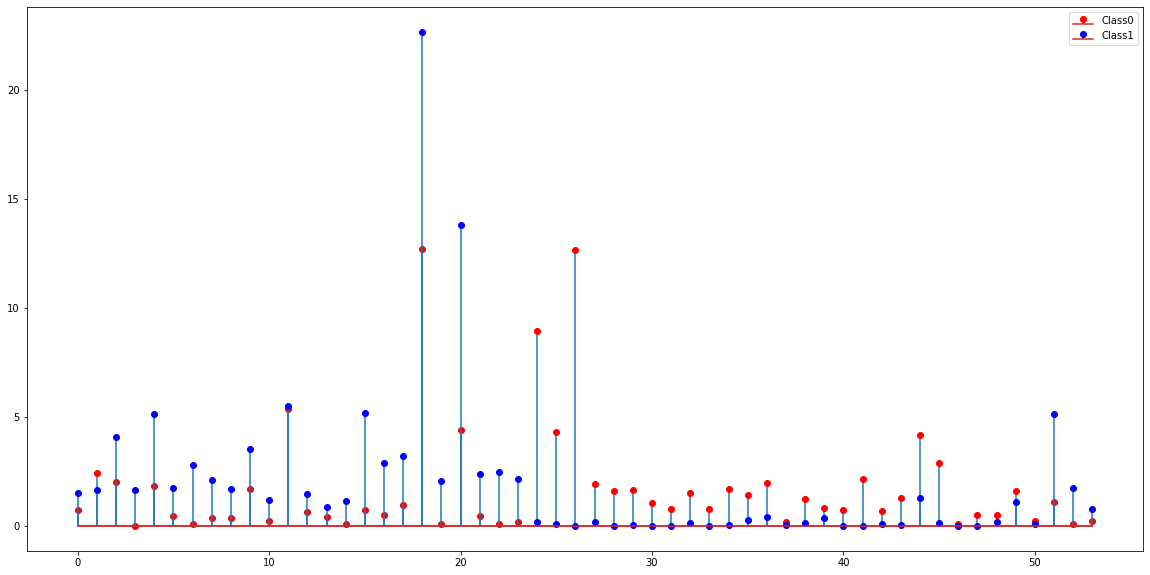

In [160]:
fig = plt.figure(figsize=(20,10))
plt.stem(lambda0.index, lambda0, label='Class0', markerfmt='ro')
plt.stem(lambda0.index, lambda1, label='Class1', markerfmt='bo')
plt.legend()
plt.show()

In feature 16 and 52 both have a higher value of lambda in class 1 and much lower value of lambda in class0, which means that the email contains "free" and "!" has a higher chance to be classified as a spam email.

In [161]:
# Feature16
print('Feature 16: Free, ', 'Class 0: ', lambda0[15], 'Class 1: ', lambda1[15])
# Feature52
print('Feature 52: !, ', 'Class 0: ', lambda0[51], 'Class 1: ', lambda1[51])

Feature 16: Free,  Class 0:  0.7395760282588606 Class 1:  5.214005750110287
Feature 52: !,  Class 0:  1.0961513031345622 Class 1:  5.128924515960302


### (c)

In [3]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']

y['target'] = y.replace({0:-1})
X = pd.concat([X, pd.DataFrame(np.ones(X.shape[0]))], axis=1)
data_nb = pd.concat([X, y], axis=1)

### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index(drop=True)
data_cv = np.array_split(data_temp, 10)

In [75]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weight = None
    
    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))
    
    def likelihood(self, X, y):
        h = self.sigmoid(y * np.dot(X, self.weight))
        return np.sum(np.log(h))
    
    def ascent(self, X, y):
        likelihood_history = []
        for i in range(self.n_iter):
            gradient = X.T @ (y * (1- self.sigmoid(y * (X @ self.weight))))
            self.weight += self.lr * gradient
            likelihood_history.append(self.likelihood(X, y))
            #print('Iteration: ', i, 'Likelihood: ', likelihood_history[-1])
        return likelihood_history
    
    def newton_method(self,X, y):
        n = X.shape[0]
        likelihood_list = []
        for _ in range(self.n_iter):
            hessian = self.hessian(X, y)
            gradient = X.T @ (y * (1- self.sigmoid(y * (X@self.weight))))/n
            self.weight += self.lr*np.linalg.inv(hessian)@gradient
            likehood_value = self.likelihood(X, y)
            likelihood_list.append(likehood_value)
        return likelihood_list
    
    def fit(self, X, y, method = 'ascent'):
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        self.weight = np.zeros((X.shape[1], 1))
        if method == 'ascent':
            likelihood_list = self.ascent(X, y)
        elif method == 'newton':
            likelihood_list = self.newton_method(X, y)
        return likelihood_list
    
    def predict(self, X):
        prob = self.sigmoid(X@self.weight)
        prob = prob.squeeze().reset_index(drop=True)
        result = pd.Series([1 if prob[i] > 0.5 else -1 for i in range(len(prob))])
        return result
    
    def accuracy(self, y_true, y_predict):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_predict = pd.Series(y_predict).reset_index(drop=True)
        return np.sum(y_true == y_predict)/len(y_true)
    
    def hessian(self, X, y):
        h = self.sigmoid(y * (X@self.weight))
        D = np.diag(np.diag(h*(1-h.T)))
        return X.T@D@X
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()
        y_TN = ((y_true == -1) & (y_predict == -1)).sum()
        y_FP = ((y_true == -1) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == -1)).sum()
        return y_TP, y_TN, y_FP, y_FN

0.9282608695652174


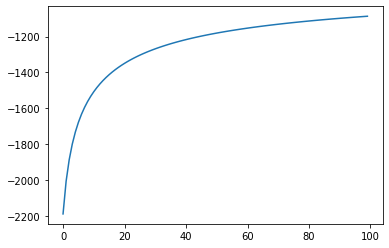

In [76]:
### For test
i=0
X_train = pd.concat(data_cv[:i]+data_cv[i+1:]).iloc[:,:-1]
y_train = pd.concat(data_cv[:i]+data_cv[i+1:]).iloc[:,-1]
X_test = data_cv[i].iloc[:,:-1].reset_index(drop=True)
y_test = data_cv[i].iloc[:,-1].reset_index(drop=True)
nb_model = LogisticRegression(learning_rate = 0.01/4600, n_iter = 100)
likelihood = nb_model.fit(X_train, y_train)
y_predicted = nb_model.predict(X_test)
print(nb_model.accuracy(y_test, y_predicted))
plt.plot(likelihood)
plt.show()

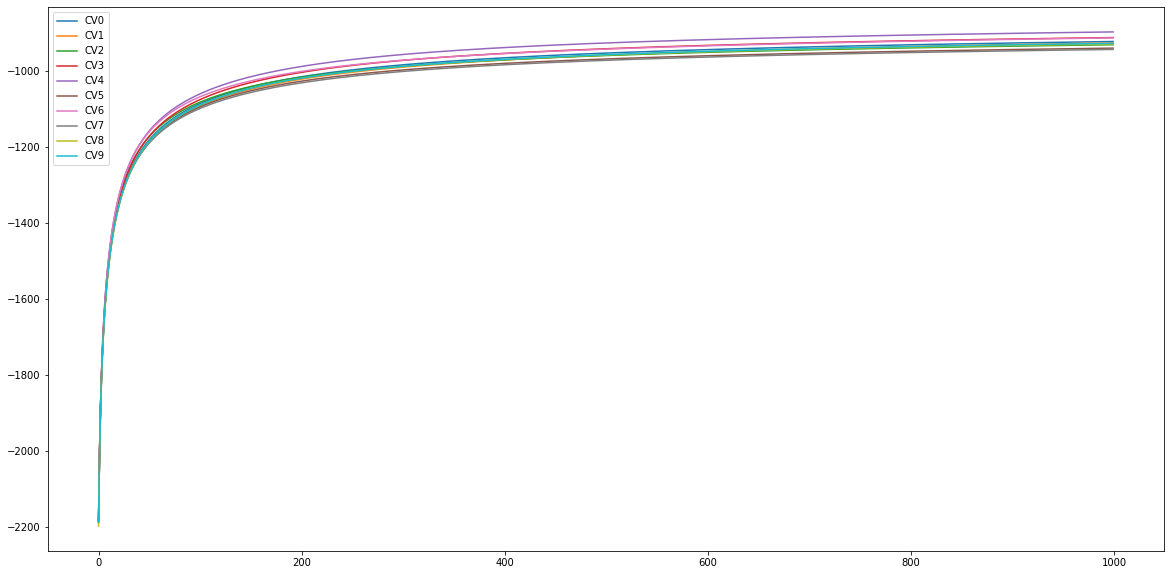

Accuracy:  0.9267391304347825


In [68]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = LogisticRegression(learning_rate = 0.01/4600, n_iter = 1000)
    likelihood = nb_model.fit(X_train, y_train)
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)


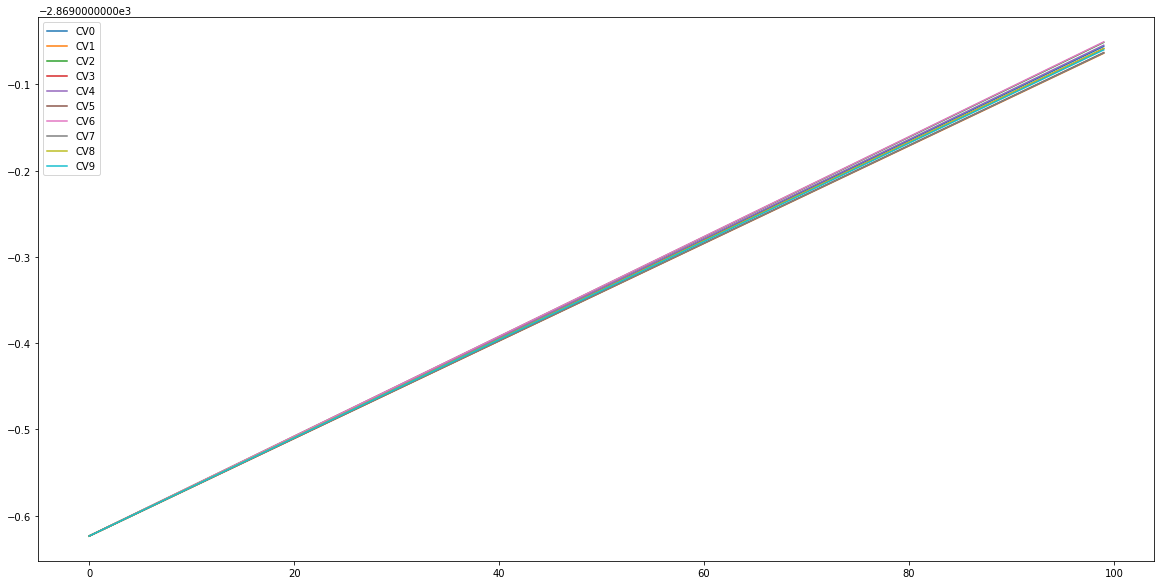

Accuracy:  0.8843478260869565
-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1415            134 
 Predicted 0      398             2653 
-------------------------------------


In [69]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Logistic_Regression(learning_rate = 0.01, n_iter = 100)
    likelihood = nb_model.fit(X_train, y_train, 'newton')
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, y_predicted)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))

### Probelm3

### (a)

In [2]:
X_train = pd.read_csv("Gaussian_process/X_train.csv", header=None).to_numpy()
y_train = pd.read_csv("Gaussian_process/y_train.csv", header=None).to_numpy()
X_test = pd.read_csv("Gaussian_process/X_test.csv", header=None).to_numpy()
y_test = pd.read_csv("Gaussian_process/y_test.csv", header=None).to_numpy()

In [35]:
class Gaussian_Process:
    def __init__(self, b, sigma) -> None:
        self.b = b
        self.sigma = sigma
    
    def cal_kernel(self, X_i, X_j):
        result = np.zeros((X_i.shape[0], X_j.shape[0]))
        for i in range(X_i.shape[0]):
            for j in range(X_j.shape[0]):
                result[i][j] = np.exp(-np.linalg.norm(X_i[i]-X_j[j])**2/self.b)
        return result
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.kernel = self.cal_kernel(X, X)
        self.kernel_mean = np.linalg.inv(np.eye(self.kernel.shape[0])*self.sigma + self.kernel)
    
    def predict(self, X):
        k = self.cal_kernel(X, self.X)
        return k @ self.kernel_mean @ self.y
    
    def RMSE(self, y_true, y_predict):
        return np.sqrt(np.mean((y_true-y_predict)**2))

In [84]:
result_df = pd.DataFrame()
lowest_rmse = 100
result_df['b'] = [i/10 for i in range(1,11)]
for b in [5,7,9,11,13,15]:
    rmse_list = []
    for sigma in range(1, 11):
        sigma = sigma/10
        GP_model = Gaussian_Process(b, sigma)
        GP_model.fit(X_train, y_train)
        y_predict = GP_model.predict(X_test)
        rmse = GP_model.RMSE(y_test, y_predict)
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            best_paramter = (b, sigma)
        rmse_list.append(rmse)
    result_df[b] = rmse_list

In [85]:
result_df

,b,5,7,9,11,13,15
0,0.1,1.966278,1.920165,1.897651,1.890509,1.895850,1.909605
1,0.2,1.933137,1.904878,1.902521,1.914983,1.935588,1.959551
2,0.3,1.923422,1.908082,1.917650,1.938851,1.964600,1.990806
3,0.4,1.922200,1.915904,1.932517,1.957938,1.985504,2.011918
4,0.5,1.924771,1.924806,1.945702,1.973218,2.001316,2.027372
5,0.6,1.929215,1.933704,1.957237,1.985766,2.013881,2.039467
6,0.7,1.934636,1.942256,1.967406,1.996377,2.024313,2.049465
7,0.8,1.940585,1.950382,1.976494,2.005605,2.033309,2.058107
8,0.9,1.946822,1.958095,1.984743,2.013838,2.041320,2.065847
9,1.0,1.953215,1.965440,1.992344,2.021347,2.048644,2.072978


### (b)

In [89]:
print("Best Parameter: ", best_paramter, '  RMSE: ', lowest_rmse)

Best Parameter:  (11, 0.1)   RMSE:  1.890509034564076


### (c)

In [37]:
X_train = pd.read_csv("Gaussian_process/X_train.csv", header=None)
y_train = pd.read_csv("Gaussian_process/y_train.csv", header=None)
X_test = pd.read_csv("Gaussian_process/X_test.csv", header=None)
y_test = pd.read_csv("Gaussian_process/y_test.csv", header=None)

X = pd.concat((X_train, X_test), axis=0)
y = pd.concat((y_train, y_test), axis=0)

In [29]:
X.head()

,0,1,2,3,4,5,6
0,0.30958,-0.36707,0.45545,-0.200830,-0.73992,-0.80885,1
1,0.30957,0.35920,-0.11611,-0.038361,0.16625,-0.80885,1
2,-0.86291,-0.99778,-0.89551,-1.225100,-0.55868,-0.26592,1
3,-0.86291,-0.69198,-0.42787,-0.562260,-0.15997,1.09140,1
4,-0.86291,-0.92133,-0.63571,-1.251000,-0.41369,0.81993,1


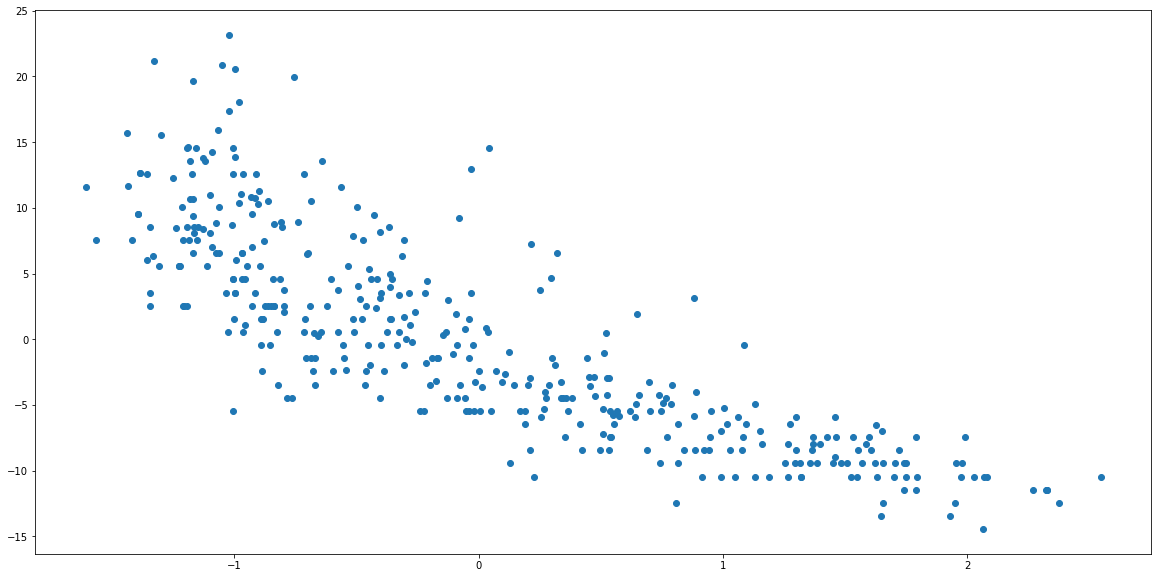

In [21]:
fig = plt.figure(figsize=(20,10))
car_weight = X.iloc[:,3]
plt.scatter(car_weight, y)

In [69]:
type(np.sort(X_train[:,3]))

numpy.ndarray

In [85]:
b = 5
sigma = 2
GP_model = Gaussian_Process(b, sigma)
GP_model.fit(car_weight.to_numpy(), y.to_numpy())
y_predict = GP_model.predict(np.sort(np.array(car_weight)))

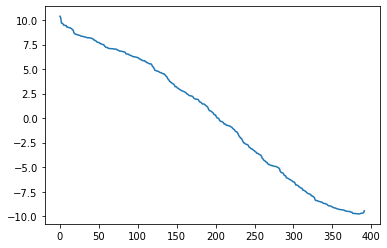

In [86]:
plt.plot(y_predict)

In [90]:
car_weight.shape

(392,)

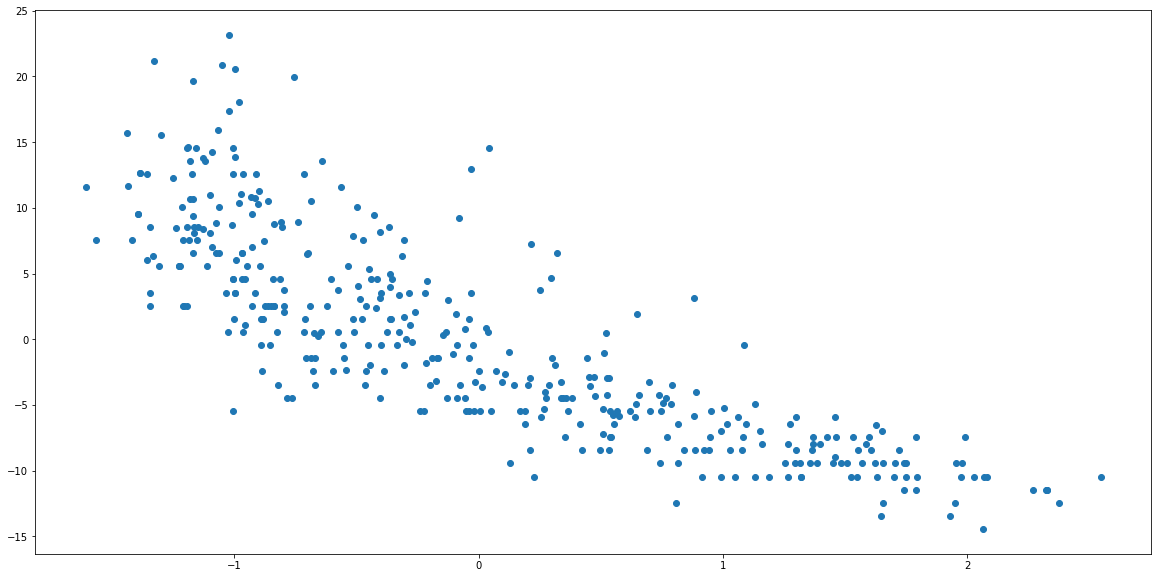

In [89]:
fig = plt.figure(figsize=(20,10))
plt.scatter(car_weight, y)
plt.show()